In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import skew, kurtosis, jarque_bera

sns.set_theme()

In [2]:
aapl = yf.download('AAPL',
                    start = '2020-01-01',
                    end = '2025-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
aapl.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400
2020-01-03,72.009125,72.771752,71.783969,71.941336,146322800
2020-01-06,72.582909,72.621646,70.876075,71.127866,118387200
2020-01-07,72.241539,72.849216,72.021223,72.592586,108872000
2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200


<Axes: xlabel='Date'>

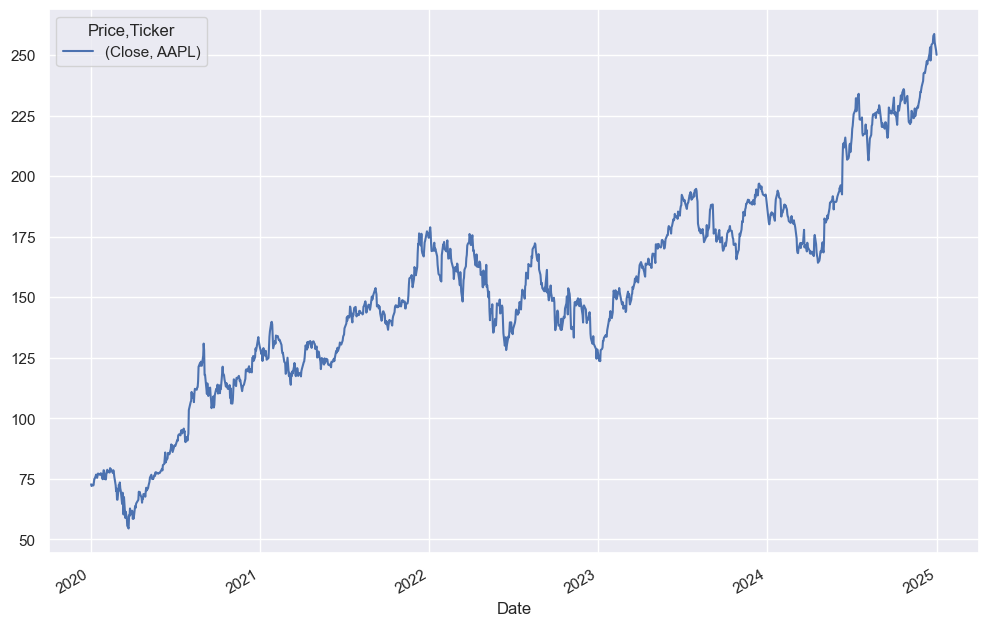

In [4]:
aapl[[('Close', 'AAPL')]].plot(kind = 'line', figsize = (12, 8))

In [5]:
close_values = aapl[('Close', 'AAPL')]
aapl[('log_returns', 'AAPL')] = np.log(close_values / close_values.shift(1))
aapl.dropna(inplace = True)

In [6]:
aapl.head()

Price,Close,High,Low,Open,Volume,log_returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-03,72.009125,72.771752,71.783969,71.941336,146322800,-0.009770
2020-01-06,72.582909,72.621646,70.876075,71.127866,118387200,0.007937
2020-01-07,72.241539,72.849216,72.021223,72.592586,108872000,-0.004714
2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200,0.015958
2020-01-09,74.962799,75.156480,74.132383,74.384166,170108400,0.021018


<Axes: xlabel='Date'>

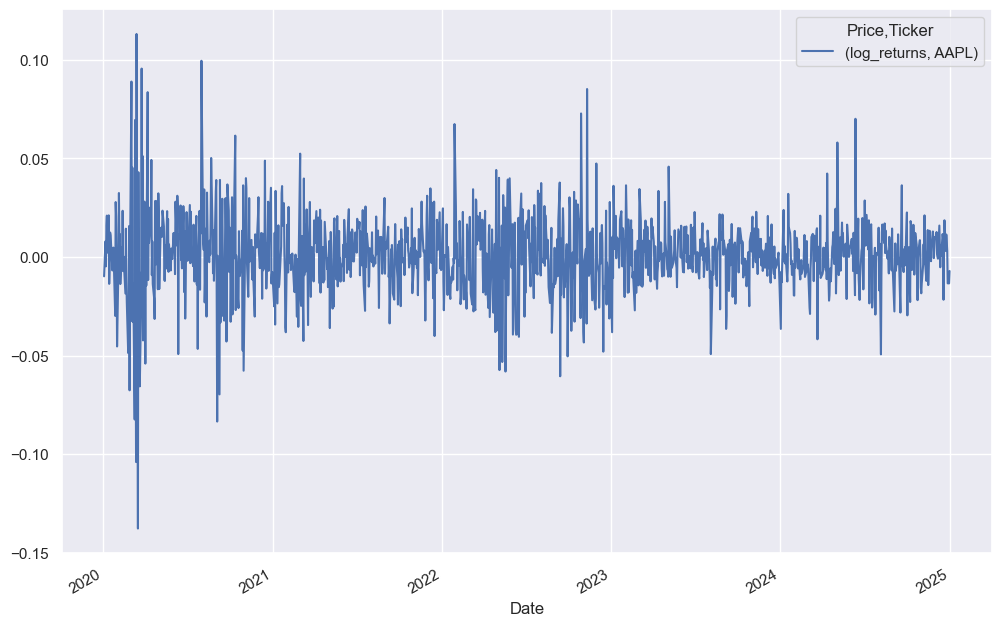

In [7]:
aapl[[('log_returns', 'AAPL')]].plot(kind = 'line', figsize = (12, 8))

<Axes: ylabel='Frequency'>

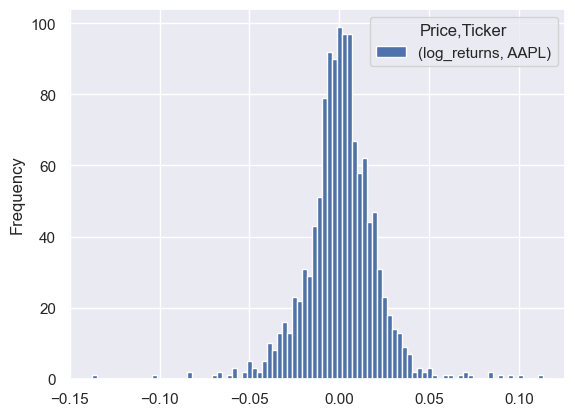

In [8]:
aapl[[('log_returns', 'AAPL')]].plot(kind = 'hist', bins = 90)

In [9]:
jarque_bera(aapl[[('log_returns', 'AAPL')]])

SignificanceResult(statistic=np.float64(1505.772393408893), pvalue=np.float64(0.0))

Veamos que el p-valor es inferir al nivel de significanci $\alpha = 0,05$

### Movimiento Browniano Geometrico
$$S_t = S_{(t-1)} e^{(\mu \Delta t + \sigma \varepsilon \sqrt{\Delta t})}$$

Donde $\varepsilon$ sigue una distribucion Normal estandar $(\varepsilon \sim N(0,1))$

In [60]:
tickers = ['NFLX', 'TSLA', 'BRK-B']

data = yf.download(tickers, start = '2020-08-17', end='2021-08-16', group_by='ticker', threads=True)

[*********************100%***********************]  3 of 3 completed


<Axes: xlabel='Date'>

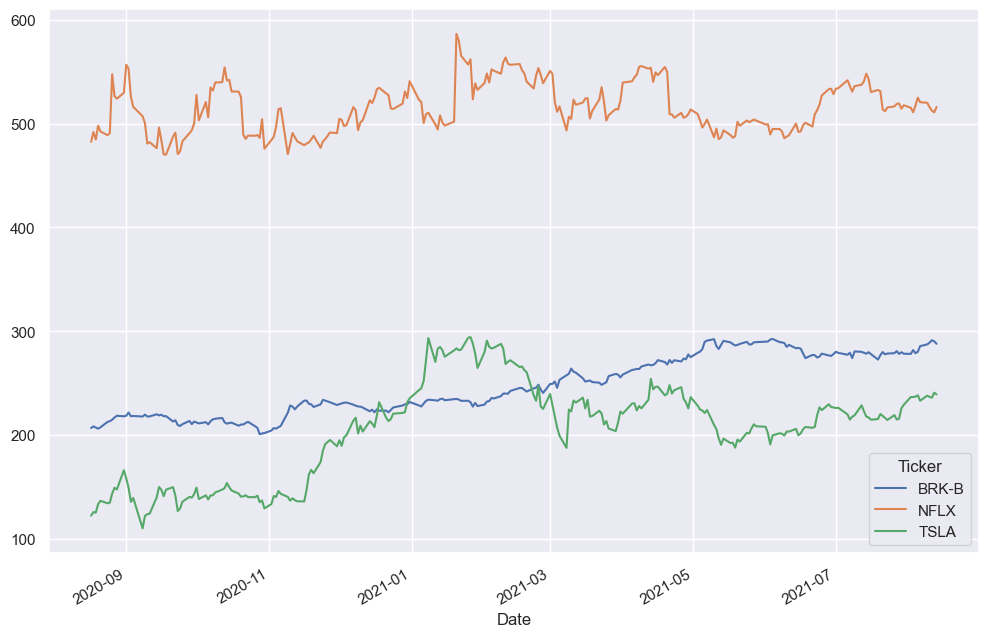

In [61]:
close_prices = data.xs('Close', axis=1, level=1)
close_prices.plot(kind = 'line', figsize = (12, 8))

<Axes: xlabel='Date'>

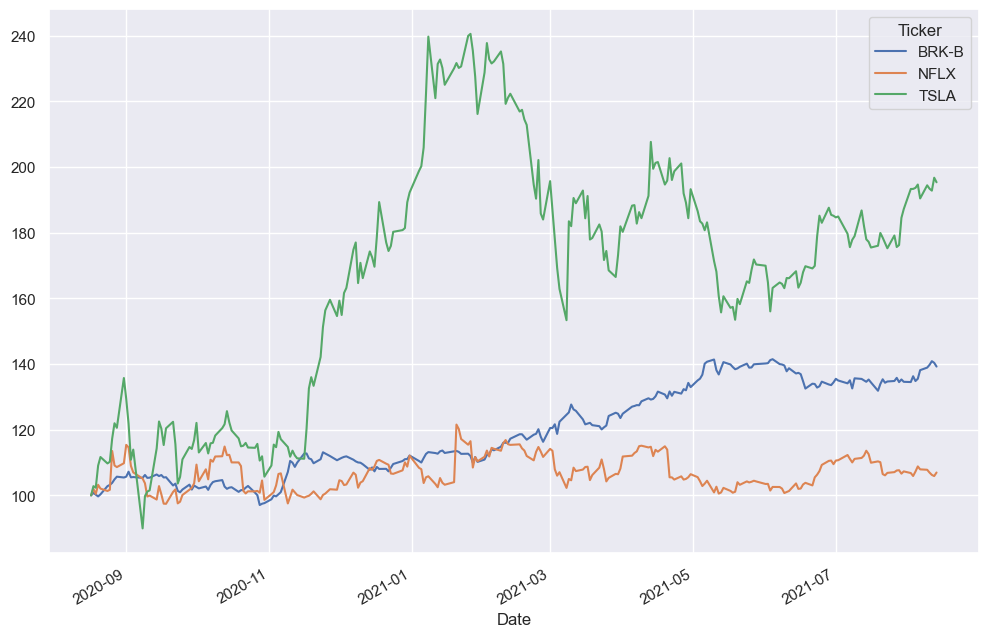

In [62]:
normalize_prices = close_prices.div(close_prices.iloc[0]).mul(100)
normalize_prices.plot(kind = 'line', figsize=(12, 8))

In [63]:
simple_returns = close_prices.pct_change().dropna()

<Axes: xlabel='Date'>

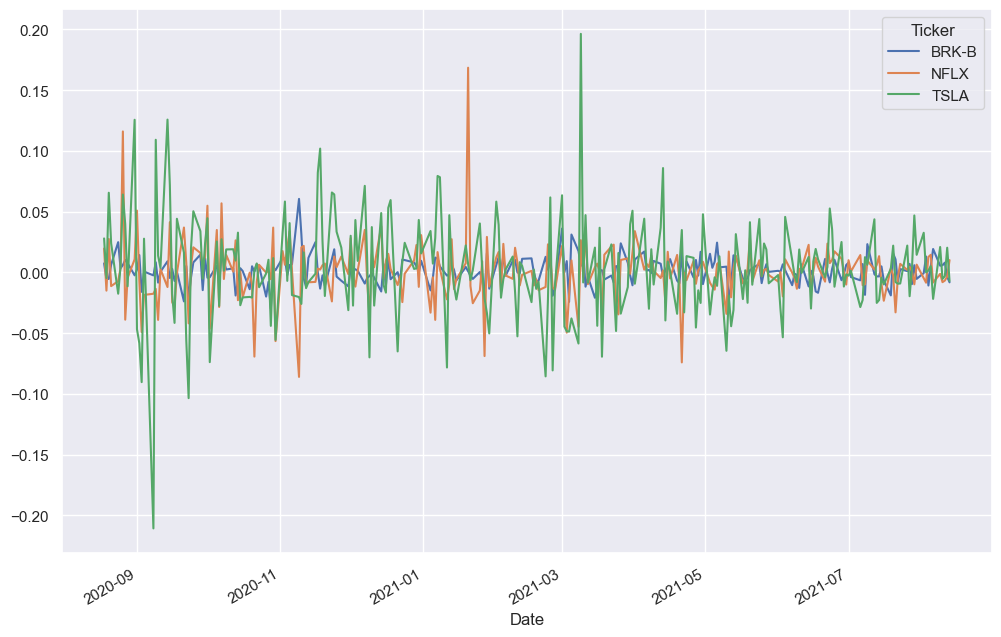

In [64]:
simple_returns.plot(kind='line', figsize=(12,8))

In [65]:
daily_returns = simple_returns.apply('mean')
daily_risk = simple_returns.apply('std')

In [66]:
daily_returns

Ticker
BRK-B    0.001386
NFLX     0.000559
TSLA     0.003528
dtype: float64

In [67]:
yearly_returns = daily_returns.apply(lambda x : (1 + x)**252 -1)
yearly_risk = daily_risk.apply(lambda x : x * np.sqrt(252))

In [68]:
return_risk = pd.concat([yearly_returns, yearly_risk], axis=1)
return_risk.columns = ['yearly_returns', 'yearly_risk']

In [69]:
return_risk

,yearly_returns,yearly_risk
Ticker,,
BRK-B,0.417613,0.176487
NFLX,0.151194,0.386122
TSLA,1.428969,0.653570


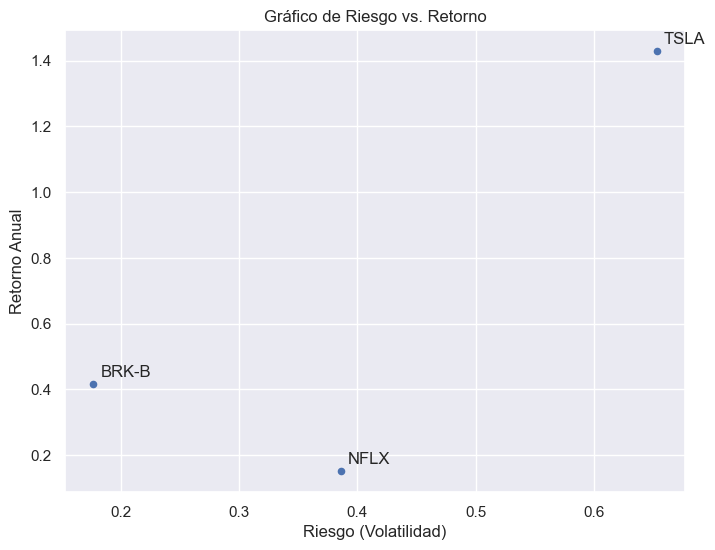

In [70]:
ax = return_risk.plot(
    kind='scatter', 
    x='yearly_risk', 
    y='yearly_returns', 
    figsize=(8,6),
    title='Gráfico de Riesgo vs. Retorno'
)

for ticker, row in return_risk.iterrows():
    ax.annotate(
        ticker,
        (row['yearly_risk'], row['yearly_returns']),
        xytext=(5,5),
        textcoords='offset points'
    )

plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Anual')
plt.show()

Ajuste de los pesos 

In [76]:
shares = {'BRK-B': 3, 'NFLX':  2, 'TSLA': 2}
weights = {x : y/sum(shares.values()) for x, y in shares.items()}

In [77]:
return_risk['yearly_returns'] @ list(weights.values())

np.float64(0.6304520417554309)

In [78]:
covariance = simple_returns.cov()

In [79]:
weighted_var = list(weights.values()) @ covariance @ list(weights.values())

In [80]:
np.sqrt(weighted_var)

np.float64(0.0163820805900867)